<h3><font color="Blue">Speech Analytics</font></h3>

In [1]:
import os
import speech_recognition as sr
import pyaudio
import wave
import pandas as pd
from pydub import AudioSegment
from pylab import*
from scipy.io import wavfile
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import thinkplot
import thinkdsp
import scipy.io.wavfile as wav
import numpy as np
import sys
lib_path = os.path.abspath(os.path.join('..'))
print(lib_path)
sys.path.append(lib_path)
from speech_feature_extraction.speechpy import processing
from speech_feature_extraction.speechpy import feature
from pyAudioAnalysis import audioBasicIO
#pip install python-magic-bin==0.4.14   # for libmagic
from pyAudioAnalysis import audioFeatureExtraction
import matplotlib.pyplot as plt
import seaborn as sb

C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


C:\Users\rishi.sinha


In [2]:
os.chdir("D:\Rishi")

In [3]:
sr.__version__

'3.8.1'

In [4]:
r = sr.Recognizer()

<h4>Reference File</h4>

In [5]:
src = "audio2.wav"  

In [6]:
check_file = os.path.exists(src)

if check_file == True:
    print ("file exists")
else:
    CHUNK = 1024
    FORMAT = pyaudio.paInt16 #paInt8
    CHANNELS = 2
    RATE = 44100 #sample rate
    RECORD_SECONDS = 10
    src = WAVE_OUTPUT_FILENAME = "output.wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK) #buffer

    print("* recording")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data) # 2 bytes(16 bits) per channel

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

file exists


<b><font color = "blue"> Listening to recorded audio </font>

In [7]:
import thinkdsp
sound = thinkdsp.read_wave(src)
sound.make_audio()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<h4> Plotting wav file </h4>

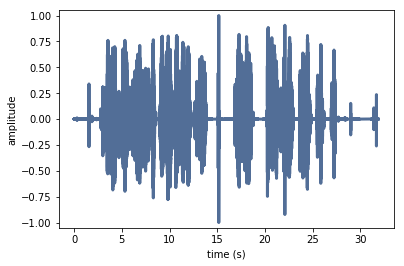

In [8]:
start = 0.12
response = sound.segment(start=start)
response.shift(-start)

response.normalize()
response.plot()
thinkplot.config(xlabel='time (s)', 
                 ylabel='amplitude', 
                 ylim=[-1.05, 1.05], 
                 legend=False)

<b><font color = "blue">Spectrogram - a common way to visualize nonperiodic signals (whose frequency components do change over time)</font></b>

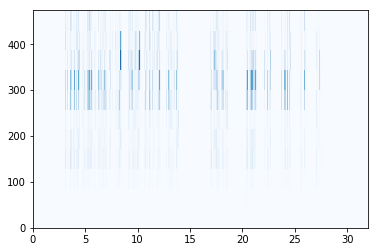

In [9]:
spectrogram = sound.make_spectrogram(seg_length=1024)
spectrogram.plot(high=500)

<b>The above spectrogram shows the spectrum over time. Spectrogram - a common way to visualize nonperiodic signals (whose frequency components do change over time).</b>

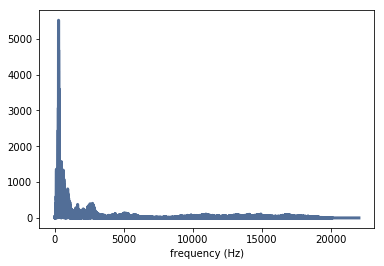

In [10]:
l = sound.make_spectrum()
l.plot()
thinkplot.config(xlabel='frequency (Hz)', legend=False)

We can select a segment where the pitch is constant:

In [13]:
start = 1.2
duration = 0.6
segment = sound.segment(start, duration)

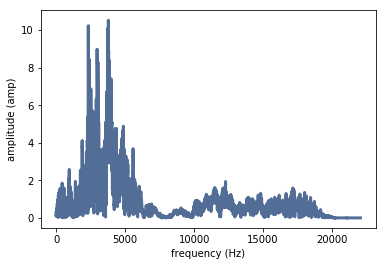

In [14]:
spectrum = segment.make_spectrum()
spectrum.plot()
thinkplot.config(xlabel='frequency (Hz)', ylabel ='amplitude (amp)', legend=False)

In [15]:
spectrum.peaks()[:5]

[(10.527451901710707, 3791.666666666667),
 (10.36403055437713, 3790.0),
 (10.342294208965699, 3793.3333333333335),
 (10.235885951480615, 2336.666666666667),
 (10.154777546465192, 2340.0)]

Plotting spectogram of one of the segment  - <b>Short-Time Fourier Transform (STFT)</b>

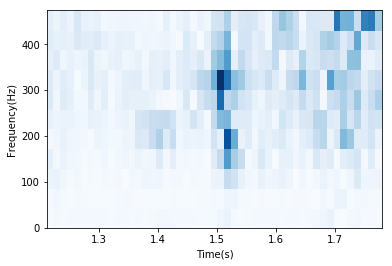

In [16]:
spectrogram = segment.make_spectrogram(seg_length=1024)
spectrogram.plot(high=500)
thinkplot.config(xlabel='Time(s)', ylabel ='Frequency(Hz)', legend=False)

<h3>Sound Processing</h3>

In [17]:
sampFreq, snd = wavfile.read(src)    

In [18]:
snd.dtype

dtype('int16')

In [19]:
sampFreq

44100

In [20]:
snd = snd / (2.**15)

In [21]:
numRows, numCols = snd.shape
snd.shape

(1411200L, 2L)

In [22]:
1411200L / sampFreq

32L

In [23]:
s1 = snd[:,0] 

Plotting the Tone

In [24]:
timeArray = arange(0, numRows, 1)
timeArray = timeArray / sampFreq
timeArray = timeArray * 1000  #scale to milliseconds

Text(0.5,0,'Time (ms)')

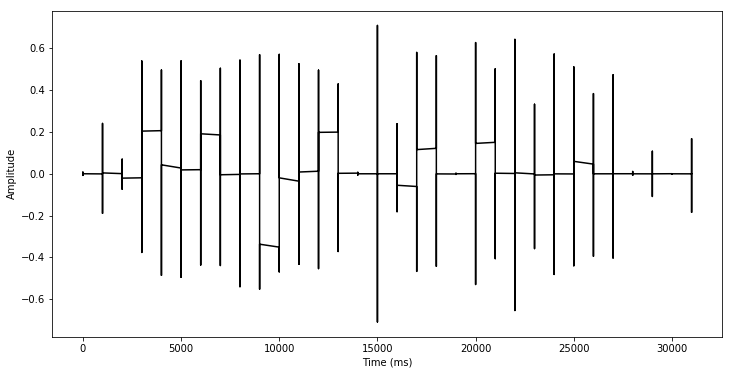

In [25]:
plt.figure(figsize=(12, 6))
plot(timeArray, s1, color='k')
ylabel('Amplitude')
xlabel('Time (ms)')

<h3> Plotting the Frequency Content</h3>

In [26]:
n = len(s1) 
p = fft(s1) # take the fourier transform 

In [27]:
nUniquePts = int(ceil((n+1)/2.0))
p = p[0:nUniquePts]
p = abs(p)

Text(0,0.5,'Power (dB)')

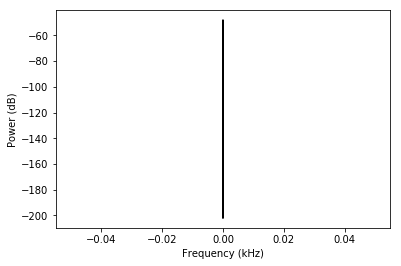

In [28]:
p = p / float(n) # scale by the number of points so that
                 # the magnitude does not depend on the length 
                 # of the signal or on its sampling frequency  
p = p**2  # square it to get the power 

# multiply by two (see technical document for details)
# odd nfft excludes Nyquist point
if n % 2 > 0: # we've got odd number of points fft
    p[1:len(p)] = p[1:len(p)] * 2
else:
    p[1:len(p) -1] = p[1:len(p) - 1] * 2 # we've got even number of points fft

freqArray = arange(0, nUniquePts, 1.0) * (sampFreq / n);
plot(freqArray/1000, 10*log10(p), color='k')
xlabel('Frequency (kHz)')
ylabel('Power (dB)')

<h3><font color ="blue">Feature Extraction </font></h3>

In [76]:
#file_name = os.path.join(os.path.dirname(os.path.abspath(__file__)),'audio2.wav')
fs, signal = wav.read(src)
signal = signal[:,0]

In [77]:
# Pre-emphasizing.
signal_preemphasized = processing.preemphasis(signal, cof=0.98)

# Staching frames
frames = processing.stack_frames(signal, sampling_frequency=fs,
                                          frame_length=0.020,
                                          frame_stride=0.01,
                                          filter=lambda x: np.ones((x,)),
                                          zero_padding=True)


In [78]:
# Extracting power spectrum
power_spectrum = processing.power_spectrum(frames, fft_points=512)
print('power spectrum shape=', power_spectrum.shape)

In [79]:
############# Extract MFCC features #############
mfcc = feature.mfcc(signal, sampling_frequency=fs,
                             frame_length=0.020, frame_stride=0.01,
                             num_filters=40, fft_length=512, low_frequency=0,
                             high_frequency=None)

Mel Frequency Cepstral Coefficents (MFCCs) introduced by Davis and Mermelstein in the 80's, 

In [80]:
# Cepstral mean variance normalization.
mfcc_cmvn = processing.cmvn(mfcc,variance_normalization=True)
print('mfcc(mean + variance normalized) feature shape=', mfcc_cmvn.shape)

 The function returns delta, the change in coefficients, and deltaDelta, the change in delta values

In [81]:
# Extracting derivative features
mfcc_feature_cube = feature.extract_derivative_feature(mfcc)
print('mfcc feature cube shape=', mfcc_feature_cube.shape)

In [82]:
############# Extract logenergy features #############
logenergy = feature.lmfe(signal, sampling_frequency=fs,
                                  frame_length=0.020, frame_stride=0.01,
                                  num_filters=40, fft_length=512,
                                  low_frequency=0, high_frequency=None)
logenergy_feature_cube = feature.extract_derivative_feature(logenergy)
print('logenergy features=', logenergy.shape)

The mfcc function processes the entire speech data in a batch. The default DeltaWindowLength is 2. Therefore, delta is computed as the difference between the current coefficients and the previous coefficients. deltaDelta is computed as the difference between the current and the previous delta values. Based on the number of input rows, the window length, and the hop length, mfcc partitions the speech into 1551 frames and computes the cepstral features for each frame. Each row in the coeffs matrix corresponds to the log-energy value followed by the 13 mel-frequency cepstral coefficients for the corresponding frame of the speech file. The function also computes loc, the location of the last sample in each input frame.

<b>Frames- Input signal splits into short-term widnows <b><p>
<b>Computing a number of features for each frame<b>

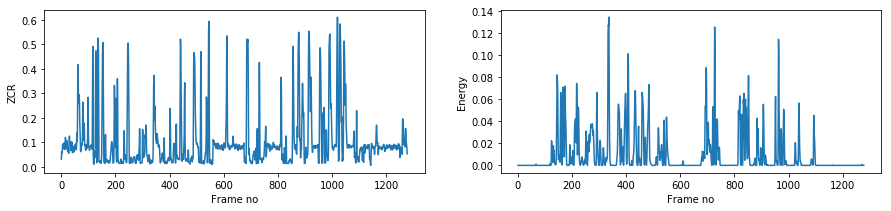

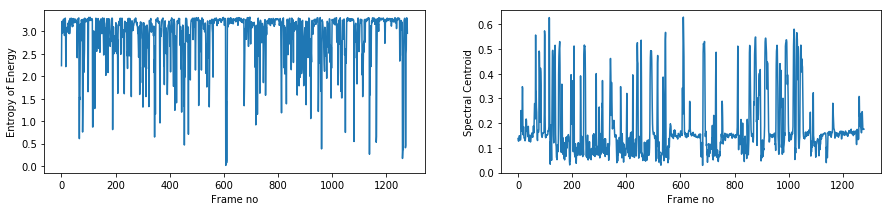

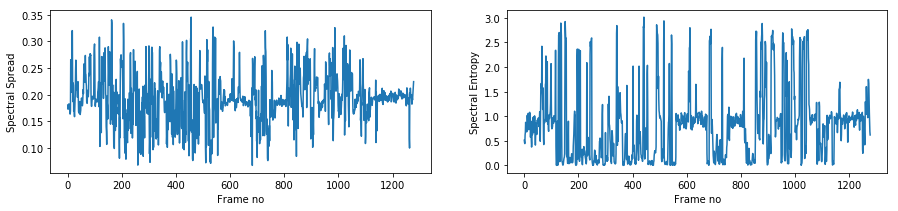

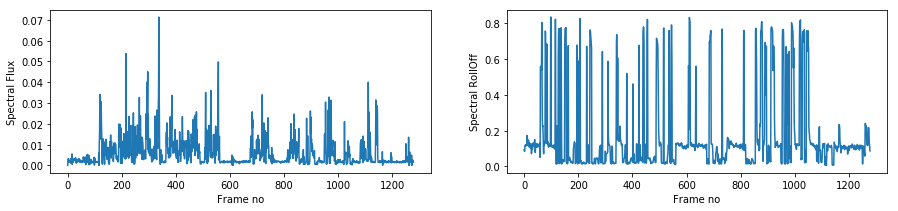

In [83]:

[Fs, x] = audioBasicIO.readAudioFile(src);
#F = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs);
F = audioFeatureExtraction.stFeatureExtraction(x[:,0], Fs, 0.050*Fs, 0.025*Fs)
fig = plt.figure(figsize=(15, 3))
plt.subplot(1,2,1); 
plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel('ZCR'); 
plt.subplot(1,2,2); 
plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel('Energy'); plt.show()
fig = plt.figure(figsize=(15, 3))
plt.subplot(1,2,1); 
plt.plot(F[2,:]); plt.xlabel('Frame no'); plt.ylabel('Entropy of Energy'); 
plt.subplot(1,2,2); 
plt.plot(F[3,:]); plt.xlabel('Frame no'); plt.ylabel('Spectral Centroid'); plt.show()
fig = plt.figure(figsize=(15, 3))
plt.subplot(1,2,1); 
plt.plot(F[4,:]); plt.xlabel('Frame no'); plt.ylabel('Spectral Spread'); 
plt.subplot(1,2,2); 
plt.plot(F[5,:]); plt.xlabel('Frame no'); plt.ylabel('Spectral Entropy'); plt.show()
fig = plt.figure(figsize=(15, 3))
plt.subplot(1,2,1); 
plt.plot(F[6,:]); plt.xlabel('Frame no'); plt.ylabel('Spectral Flux'); 
plt.subplot(1,2,2); 
plt.plot(F[7,:]); plt.xlabel('Frame no'); plt.ylabel('Spectral RollOff'); plt.show()

In [84]:
pd.options.display.float_format = '{:.3f}'.format
Sound_Features_df = pd.DataFrame({'Zero Crossing Rate':F[0,:],'Energy':F[1,:], 'Entropy of Energy':F[2,:],'Spectral Centroid':F[3,:], 'Spectral Spread':F[4,:],'Spectral Entropy':F[5,:], 'Spectral Flux':F[6,:],'Spectral Rolloff':F[7,:], 'MFCCs(1)':F[8,:], 'MFCCs(2)':F[9,:], 'MFCCs(3)':F[10,:], 'MFCCs(4)':F[11,:], 'MFCCs(5)':F[12,:], 'MFCCs(6)':F[13,:],'MFCCs(7)':F[14,:], 'MFCCs(8)':F[15,:], 'MFCCs(9)':F[16,:], 'MFCCs(10)':F[17,:], 'MFCCs(11)':F[18,:], 'MFCCs(12)':F[19,:], 'MFCCs(13)':F[20,:],'Chroma Vector(1)':F[21,:], 'Chroma Vector(2)':F[22,:], 'Chroma Vector(3)':F[23,:], 'Chroma Vector(4)':F[24,:], 'Chroma Vector(5)':F[25,:], 'Chroma Vector(6)':F[26,:], 'Chroma Vector(7)':F[27,:], 'Chroma Vector(8)':F[28,:], 'Chroma Vector(9)':F[29,:], 'Chroma Vector(10)':F[30,:], 'Chroma Vector(11)':F[31,:], 'Chroma Vector(12)':F[32,:],'Chroma Deviation':F[33,:]})
Sound_Features_df.insert(0, 'Frame_No', range(1, 1+ len(Sound_Features_df)))

In [38]:
Sound_Features_df.set_index('Frame_No', inplace=True)
Sound_Features_df.head()
#Sound_Features_df.to_csv(Audio_Features, sep='\t', encoding='utf-8')

Chroma Deviation  Chroma Vector(1)  Chroma Vector(10)  \
Frame_No                                                          
1                    0.011             0.005              0.003   
2                    0.006             0.014              0.001   
3                    0.008             0.011              0.006   
4                    0.011             0.013              0.008   
5                    0.009             0.018              0.005   

          Chroma Vector(11)  Chroma Vector(12)  Chroma Vector(2)  \
Frame_No                                                           
1                     0.005              0.004             0.036   
2                     0.010              0.004             0.022   
3                     0.015              0.007             0.018   
4                     0.012              0.012             0.009   
5                     0.018              0.018             0.001   

          Chroma Vector(3)  Chroma Vector(4)  Chroma Vector(5)  \
Frame_No                                                         
1                    0.018             0.024             0.002   
2                    0.010             0.017             0.008   
3                    0.024             0.018             0.004   
4                    0.024             0.035             0.037   
5                    0.012             0.018             0.032   

          Chroma Vector(6)         ...          MFCCs(6)  MFCCs(7)  MFCCs(8)  \
Frame_No                           ...                                         
1                    0.005         ...            -0.275    -0.404     0.835   
2                    0.006         ...            -0.670    -0.564     0.585   
3                    0.026         ...            -0.868    -0.464     0.412   
4                    0.015         ...            -0.958    -0.368     0.442   
5                    0.021         ...            -0.857    -0.405     0.151   

          MFCCs(9)  Spectral Centroid  Spectral Entropy  Spectral Flux  \
Frame_No                                                                 
1            0.414              0.137             0.513          0.000   
2            0.084              0.128             0.467          0.001   
3            0.057              0.129             0.444          0.003   
4           -0.369              0.128             0.621          0.003   
5           -0.492              0.136             0.679          0.002   

          Spectral Rolloff  Spectral Spread  Zero Crossing Rate  
Frame_No                                                         
1                    0.093            0.180               0.030  
2                    0.084            0.173               0.061  
3                    0.083            0.181               0.057  
4                    0.116            0.174               0.056  
5                    0.117            0.183               0.077  

[5 rows x 34 columns]

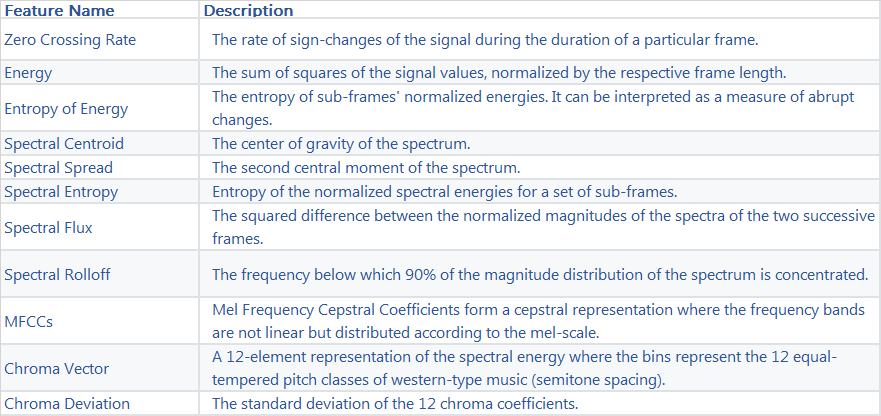

In [85]:
#Sound_Features_df.to_csv(Audio_Features, sep='\t')#, encoding='utf-8')
#Sound_Features_df.to_csv('out.csv', sep=',')

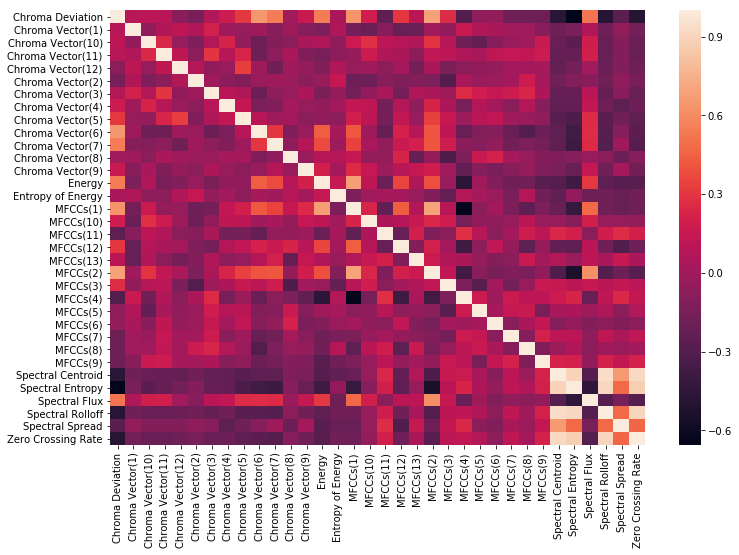

In [40]:
fig = plt.figure(figsize=(12, 8))
sb.heatmap(Sound_Features_df.corr()) 

<h3>Classification</h3>

In [86]:
from pyAudioAnalysis import audioTrainTest as aT
aT.fileClassification(src, "./file","svm")

(-1, -1, -1)

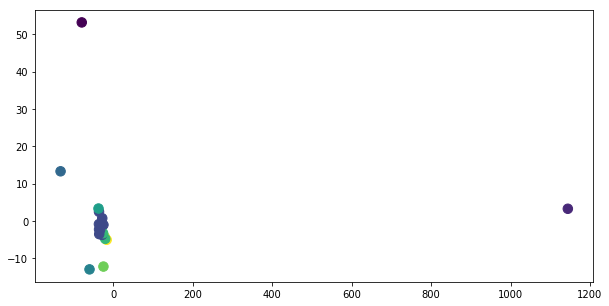

In [42]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

transposed_data = np.transpose(Sound_Features_df) 

# PCA here.
pca = PCA(n_components=11)
pca.fit(transposed_data)

X_pca = pca.transform(transposed_data)

# Appllying clustering here...
km = KMeans(n_clusters=10, init='k-means++',n_init=20, verbose=0);
km.fit(X_pca);
cluster_pred = km.predict(X_pca);

plt.figure(figsize=(10,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_pred, s=90, cmap='viridis', alpha = 10)
#plt.scatter(x, y, s=area, c=colors, alpha=0.8)
plt.show()

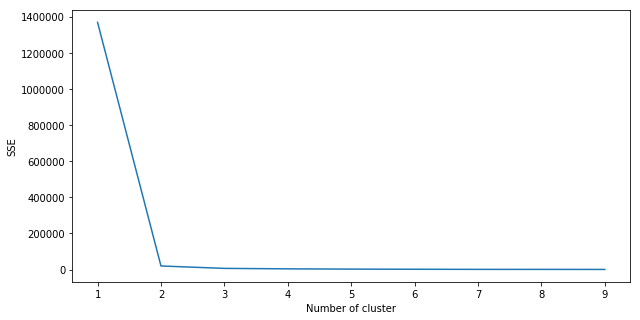

In [89]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_pca)
    #df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [90]:
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(X_pca)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [91]:
Sound_Features_df = Sound_Features_df.assign(cluster=pd.Series(kmeans.labels_))
Sound_Features_df.head()

Frame_No  Chroma Deviation  Chroma Vector(1)  Chroma Vector(10)  \
0         1             0.011             0.005              0.003   
1         2             0.006             0.014              0.001   
2         3             0.008             0.011              0.006   
3         4             0.011             0.013              0.008   
4         5             0.009             0.018              0.005   

   Chroma Vector(11)  Chroma Vector(12)  Chroma Vector(2)  Chroma Vector(3)  \
0              0.005              0.004             0.036             0.018   
1              0.010              0.004             0.022             0.010   
2              0.015              0.007             0.018             0.024   
3              0.012              0.012             0.009             0.024   
4              0.018              0.018             0.001             0.012   

   Chroma Vector(4)  Chroma Vector(5)   ...     MFCCs(7)  MFCCs(8)  MFCCs(9)  \
0             0.024             0.002   ...       -0.404     0.835     0.414   
1             0.017             0.008   ...       -0.564     0.585     0.084   
2             0.018             0.004   ...       -0.464     0.412     0.057   
3             0.035             0.037   ...       -0.368     0.442    -0.369   
4             0.018             0.032   ...       -0.405     0.151    -0.492   

   Spectral Centroid  Spectral Entropy  Spectral Flux  Spectral Rolloff  \
0              0.137             0.513          0.000             0.093   
1              0.128             0.467          0.001             0.084   
2              0.129             0.444          0.003             0.083   
3              0.128             0.621          0.003             0.116   
4              0.136             0.679          0.002             0.117   

   Spectral Spread  Zero Crossing Rate  cluster  
0            0.180               0.030    0.000  
1            0.173               0.061    0.000  
2            0.181               0.057    0.000  
3            0.174               0.056    0.000  
4            0.183               0.077    0.000  

[5 rows x 36 columns]

In [92]:
Sound_Features_df['cluster'] = Sound_Features_df['cluster'].apply('{:.0f}'.format)

In [93]:
Sound_Features_df.head()

Frame_No  Chroma Deviation  Chroma Vector(1)  Chroma Vector(10)  \
0         1             0.011             0.005              0.003   
1         2             0.006             0.014              0.001   
2         3             0.008             0.011              0.006   
3         4             0.011             0.013              0.008   
4         5             0.009             0.018              0.005   

   Chroma Vector(11)  Chroma Vector(12)  Chroma Vector(2)  Chroma Vector(3)  \
0              0.005              0.004             0.036             0.018   
1              0.010              0.004             0.022             0.010   
2              0.015              0.007             0.018             0.024   
3              0.012              0.012             0.009             0.024   
4              0.018              0.018             0.001             0.012   

   Chroma Vector(4)  Chroma Vector(5)   ...     MFCCs(7)  MFCCs(8)  MFCCs(9)  \
0             0.024             0.002   ...       -0.404     0.835     0.414   
1             0.017             0.008   ...       -0.564     0.585     0.084   
2             0.018             0.004   ...       -0.464     0.412     0.057   
3             0.035             0.037   ...       -0.368     0.442    -0.369   
4             0.018             0.032   ...       -0.405     0.151    -0.492   

   Spectral Centroid  Spectral Entropy  Spectral Flux  Spectral Rolloff  \
0              0.137             0.513          0.000             0.093   
1              0.128             0.467          0.001             0.084   
2              0.129             0.444          0.003             0.083   
3              0.128             0.621          0.003             0.116   
4              0.136             0.679          0.002             0.117   

   Spectral Spread  Zero Crossing Rate  cluster  
0            0.180               0.030        0  
1            0.173               0.061        0  
2            0.181               0.057        0  
3            0.174               0.056        0  
4            0.183               0.077        0  

[5 rows x 36 columns]

In [94]:
Sound_Features_df.shape

(1279, 36)

In [95]:

from pyAudioAnalysis import audioTrainTest as aT
aT.featureAndTrain(["classifierData/music","classifierData/speech"], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm", "svmSMtemp", False)
aT.fileClassification("data/audio2.wav", "svmSMtemp","svm")

(-1, -1, -1)

In [96]:
from pyAudioAnalysis import audioTrainTest as aT
aT.fileClassification("audio2.wav", "./file","knn")

(-1, -1, -1)

In [97]:
MFCC_columns = Sound_Features_df.columns[Sound_Features_df.columns.str.contains(pat = 'MFCC') ] 

In [98]:
MFCC_columns

Index([u'MFCCs(1)', u'MFCCs(10)', u'MFCCs(11)', u'MFCCs(12)', u'MFCCs(13)',
       u'MFCCs(2)', u'MFCCs(3)', u'MFCCs(4)', u'MFCCs(5)', u'MFCCs(6)',
       u'MFCCs(7)', u'MFCCs(8)', u'MFCCs(9)'],
      dtype='object')

In [115]:
MFCC_df = Sound_Features_df[MFCC_columns]

In [118]:
MFCC_df.shape

(1279, 14)

In [119]:
MFCC_df.head()

MFCCs(1)  MFCCs(10)  MFCCs(11)  MFCCs(12)  MFCCs(13)  MFCCs(2)  MFCCs(3)  \
0   -36.669      0.031      0.034      0.331     -0.273    -0.153    -1.183   
1   -35.434     -0.252     -0.329      0.063     -0.349     0.526    -0.854   
2   -35.826     -0.198     -0.386     -0.094     -0.147     1.056    -0.570   
3   -35.721     -0.140     -0.202     -0.180     -0.465     1.082     0.100   
4   -35.939      0.010      0.004     -0.147     -0.478     0.976     0.224   

   MFCCs(4)  MFCCs(5)  MFCCs(6)  MFCCs(7)  MFCCs(8)  MFCCs(9) cluster  
0     0.459     0.586    -0.275    -0.404     0.835     0.414       0  
1     0.348     0.145    -0.670    -0.564     0.585     0.084       0  
2     0.266    -0.223    -0.868    -0.464     0.412     0.057       0  
3     0.269    -0.400    -0.958    -0.368     0.442    -0.369       0  
4     0.579    -0.270    -0.857    -0.405     0.151    -0.492       0

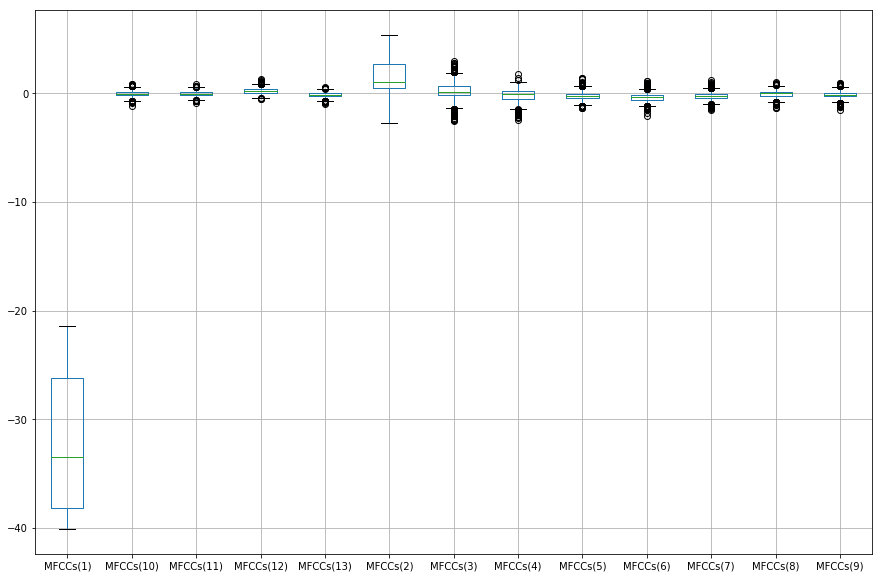

In [56]:
fig = plt.figure(figsize=(15, 10))
MFCC_df.boxplot()

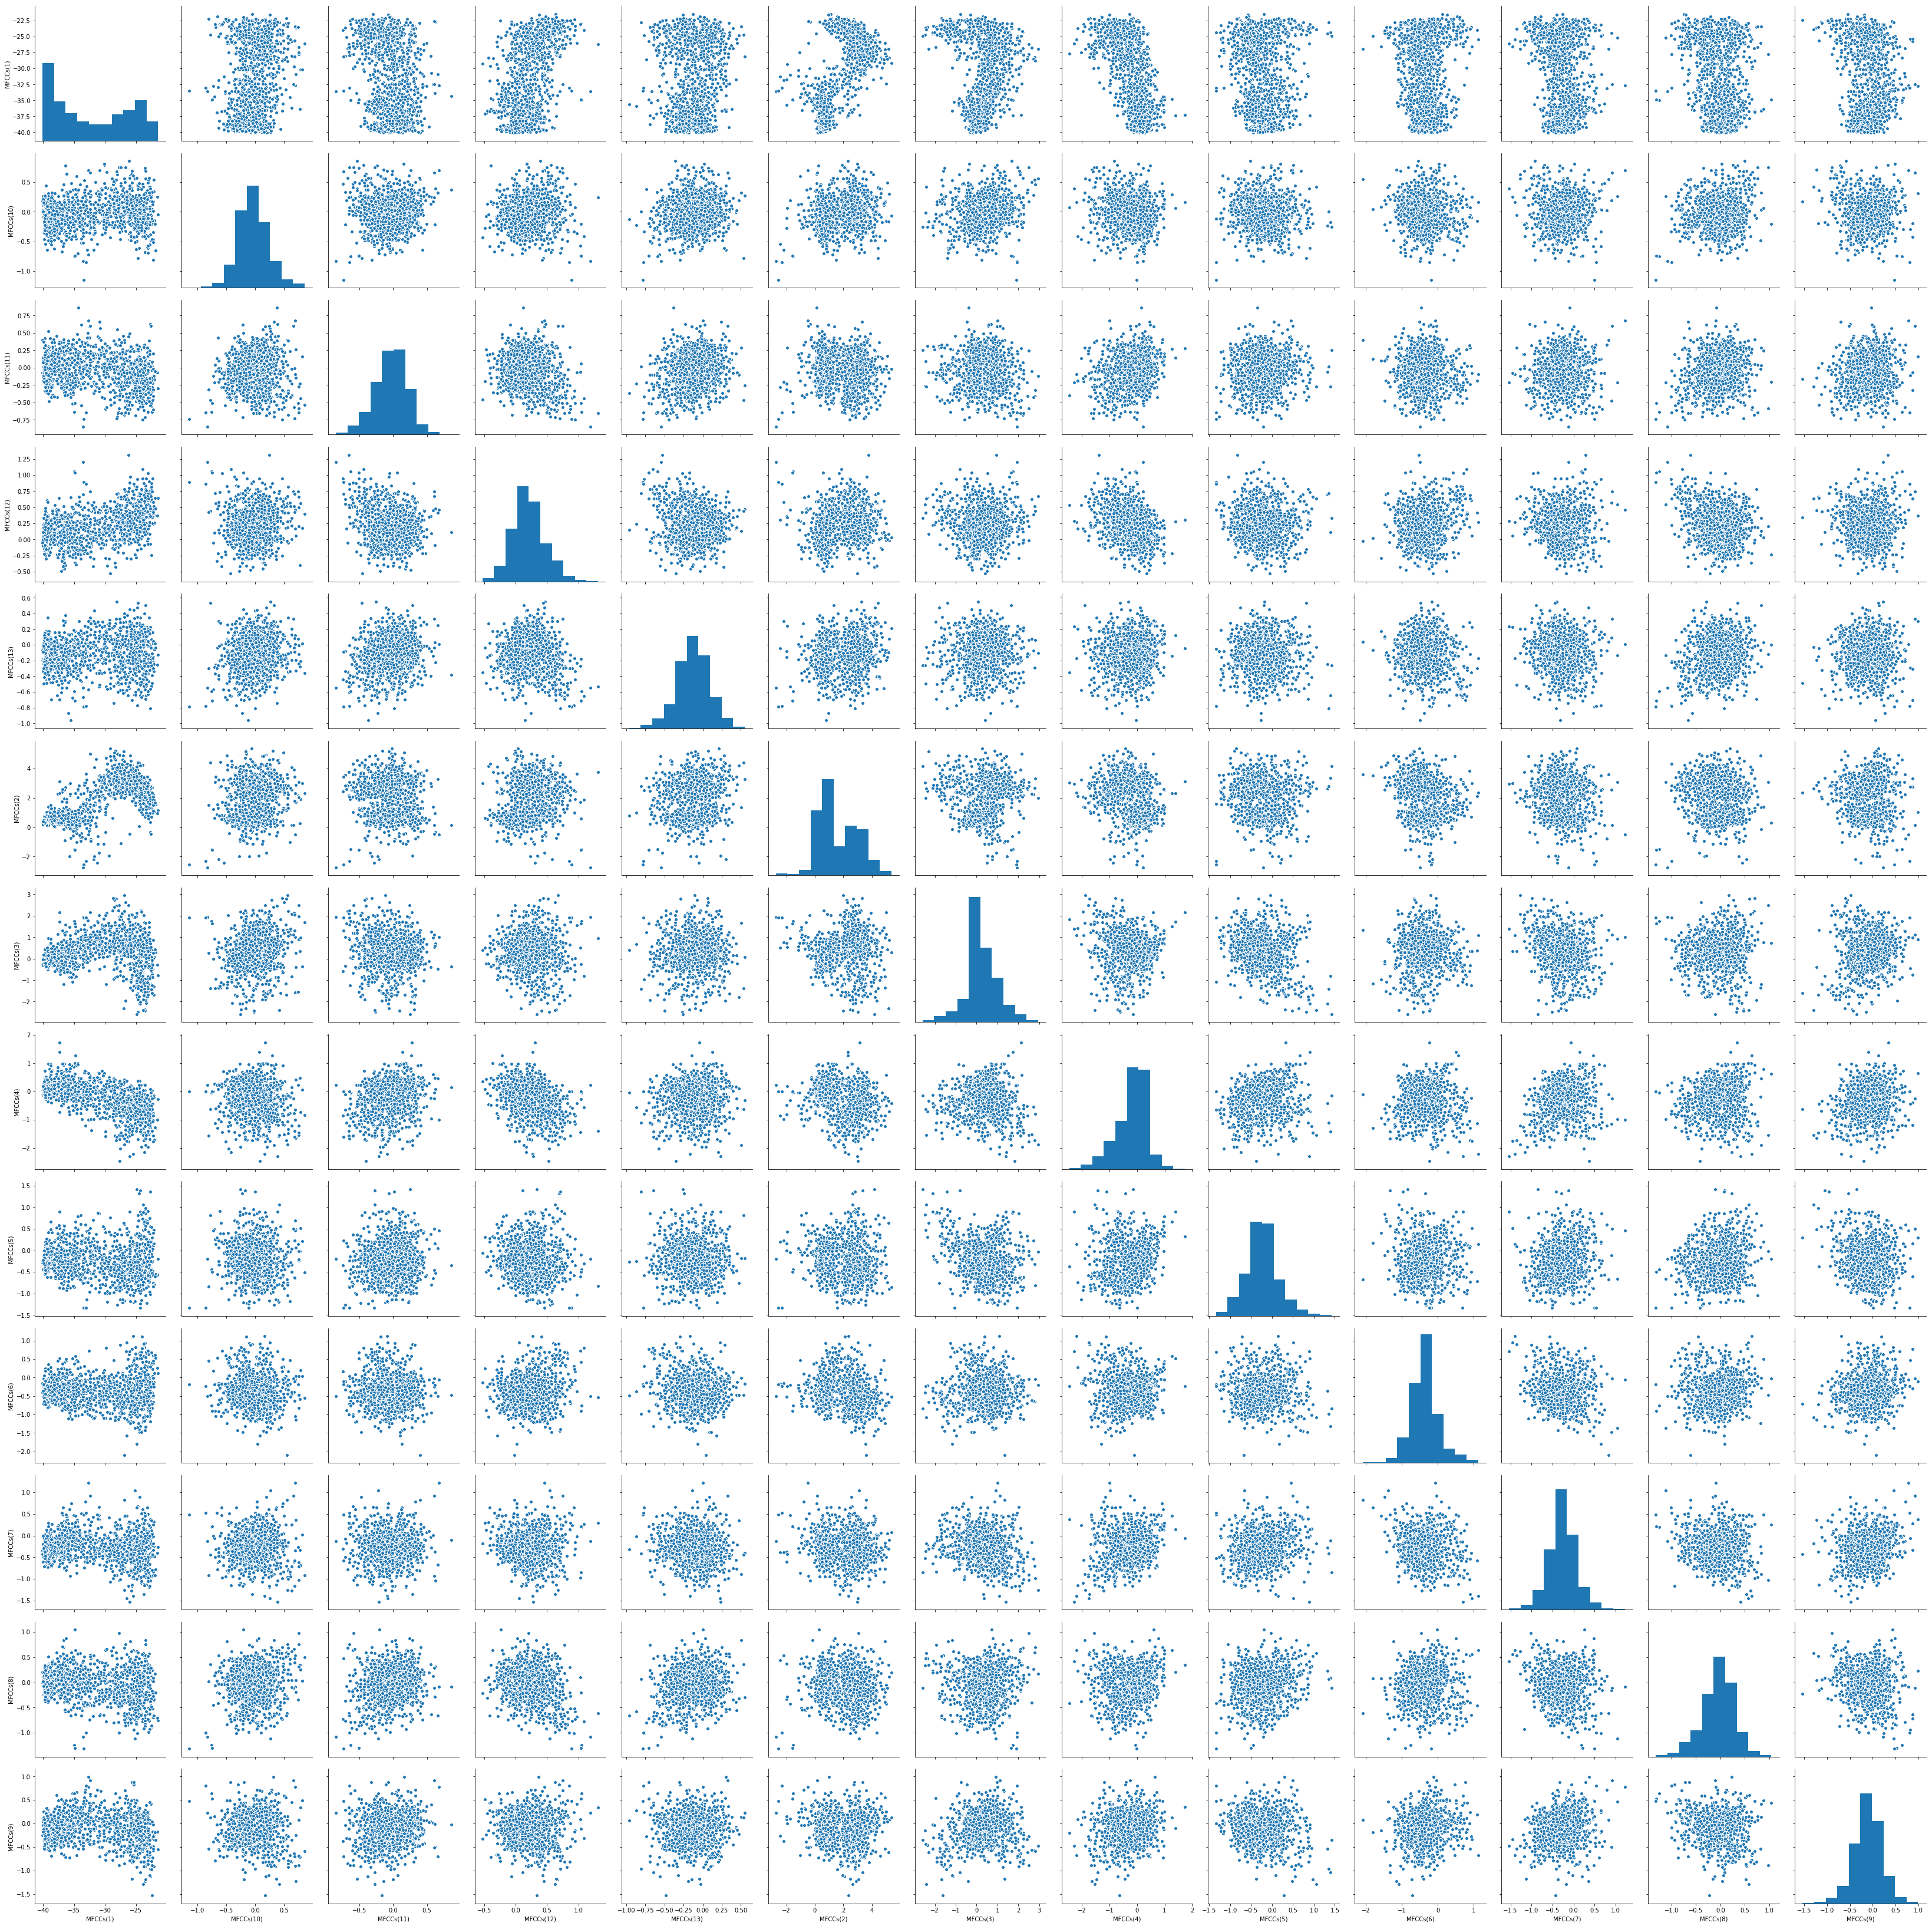

In [106]:
import seaborn as sns
sns.pairplot(MFCC_df, size=3.5)

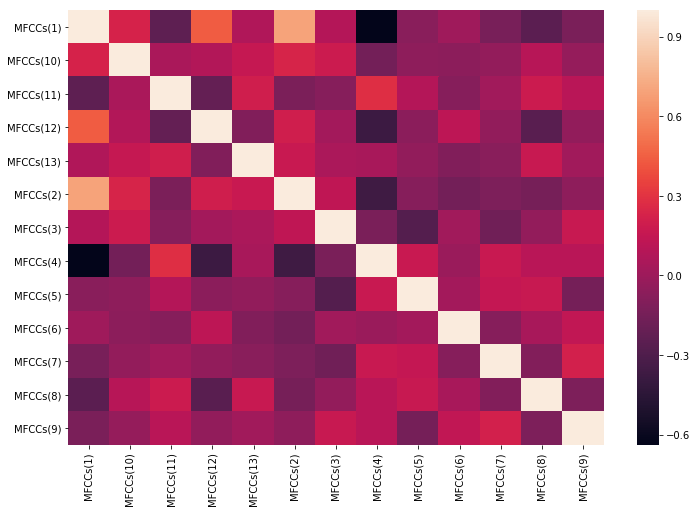

In [56]:
fig = plt.figure(figsize=(12, 8))
sb.heatmap(MFCC_df.corr()) 

<h3><font color ="blue">Speech to Text Conversion </font></h3>

In [17]:
#filename = input(src)
#f_extns = filename.split(".")
#f_extns

# above snippet will show a textbox to enter file name

#name, ext = os.path.splitext(src)
r = sr.Recognizer()   
myAudio = sr.AudioFile("audio2.wav")
with myAudio as source:
    audio = r.record(source)
r.recognize_sphinx(audio)

"this is one single one of which isn't an intense and on and do that can be used right in the broughton middle of the carpet was you seem like reform and say let me before my time when one has to speak to that it's the students flocked this singular"

In [30]:
import speech_recognition as sr

r = sr.Recognizer()
with sr.Microphone() as source:
    print ('Say Something!')
    audio = r.listen(source)
    print ('Done!')
    
text = r.recognize_google(audio)
print (text)

Say Something!
Done!
hello hello hello hello


### Using IBM Watson

In [28]:
INSTALLED_APPS = [
    'storages',
    'crispy_forms',
    'rest_framework_docs',
    'oauth2_provider',
    'rest_framework',
    'mptt',
    'django_mptt_admin',
    'sorl.thumbnail',
    'django_extensions',
    'opbeat.contrib.django',
    'softdelete',
    'cacheops',
    'channels',
]

In [3]:
from watson_developer_cloud import SpeechToTextV1
from watson_developer_cloud.websocket import RecognizeCallback, AudioSource
from os.path import join, dirname
import json

speech_to_text = SpeechToTextV1(
    username='_________',
    password='___________')

class MyRecognizeCallback(RecognizeCallback):
    def __init__(self):
        RecognizeCallback.__init__(self)

    def on_data(self, data):
        print(json.dumps(data, indent=2))

    def on_error(self, error):
        print('Error received: {}'.format(error))

    def on_inactivity_timeout(self, error):
        print('Inactivity timeout: {}'.format(error))

myRecognizeCallback = MyRecognizeCallback()

import os.path

#dirname = os.path.dirname(__file__)
    
with open(join('./.', 'Plumbing-Call-Recording.mp3'),'rb') as audio_file:
    audio_source = AudioSource(audio_file)
    speech_to_text.recognize_using_websocket(
        audio=audio_source,
        content_type='audio/mp3',
        recognize_callback=myRecognizeCallback,
        model='en-US_BroadbandModel',
        #keywords=['colorado', 'tornado', 'tornadoes'],
        #keywords_threshold=0.5,
        speaker_labels = True,
        max_alternatives=3)
        #timestamps = True,
        #speaker_labels = True)

{
  "results": [
    {
      "alternatives": [
        {
          "timestamps": [
            [
              "get",
              1.83,
              2.0
            ],
            [
              "afternoon",
              2.0,
              2.62
            ],
            [
              "thank",
              2.62,
              2.91
            ],
            [
              "you",
              2.91,
              3.01
            ],
            [
              "for",
              3.01,
              3.15
            ],
            [
              "calling",
              3.15,
              3.48
            ],
            [
              "professional",
              3.48,
              4.02
            ],
            [
              "plumbing",
              4.02,
              4.52
            ]
          ],
          "confidence": 0.906,
          "transcript": "get afternoon thank you for calling professional plumbing "
        },
        {
          "transcript": "good af